# Laboratorio 5: Optimización Multiobjetivo

**Por:** Amalia Carbonell & Santiago Casasbuenas

## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

### 1. Formulación del Modelo Multiobjetivo

#### a. Recursos

$R$: Conjunto de recursos = {alimentos, medicinas, equipos médicos, agua, mantas}

$A$: Conjunto de aviones = {1,2,3,4}

$Z$: Conjunto de zonas de destino = {A,B,C,D}

$V$: Conjunto de viajes por avión = {1,2} (Cada avión puede hacer hasta 2 viajes)

#### b. Parámetros

**Recursos:**

- $v_i$: valor de impacto social por tonelada del recurso $i$

- $p_i$: Peso por unidad del recurso $i$

- $vol_i$: Volumen por unidad del recurso $i$

- $disp_i$: Unidades disponibles del recurso $i$

**Aviones:**

- $capp_j$: Capacidad en peso del avión $j$ (TON)

- $capvol_j$: Capacidad en volumen del avión $j$ $(m^3)$

- $cfijo_j$: Costo fijo de usar avión $j$ (miles USD)

- $cvar_j$: Costo variable por km del avión $j$ (miles USD/km)

**Zonas:**

- $d_k$: Distancia a la zona k (km)

- $m_k$: Multiplicador de impacto social de la zona $k$

- $min_{ik}$: Necesidad mínima del recurso $i$ en la zona $k$

#### c. Variables de Decisión

- $x_{ijvk}$: Cantidad (TON) del recursos $i$ transportado por avión $j$ en el viaje $v$ a la zona $k$

- $y_{jvk} \in$ {0,1}: 1 si el avión $j$ en el viaje $v$ va a la zona $k$

- $v_j \in$ {0,1}: 1 si el avión $j$ es usado en al menos de un viaje, 0 si no.

- $n \_ equipos_{jvk}$: Cantidad entera de unidades de equipos transportados (por indivisibilidad)

#### d. Funciones Objetivo

**Objetivo 1**: Maximizar el valor de impacto social total

$$
Z_1 = \sum_{i \in R} \sum_{j \in A} \sum_{v \in V} \sum_{k \in Z} v_i * x_{ijvk} * m_k
$$

**Objetivo 2**: Minimizar el costo total del transporte

$$
Z_2 = \sum_{j \in A} cfijo_j * u_j + \sum_{j \in A} \sum_{v \in V} \sum_{k \in Z} cvar_j * d_k * y_{jvk}
$$


#### e. Restricciones

**Restricción 1**: capacidad de peso de cada avión por viaje

Cada avión tiene un límite de peso por viaje que no debe ser excedido.

$$
\sum_{i \in R} p_i * x_{ijvk} \leq capp_j \quad \forall j \in A, \quad \forall v \in V, \quad \forall k \in Z
$$

**Restricción 2**: Capacidad de volumen de cada avión por viaje

Cada avión tambien tiene un límite de volumen.

$$
\sum_{i \in R} vol_i * x_{ijvk} \leq capvol_j \quad \forall j \in A, \quad \forall v \in V, \quad \forall k \in Z
$$




**Restricción 3:** Seguridad de medicamentos

Los medicamentos no pueden ser transportados en el avión 1, por falta de refrigeración.

$$
x_{medicinas, 1, v, k} = 0 \quad \forall v \in V, \quad \forall k \in Z 
$$

**Restricción 4:** Incompatibilidad entre agua potable y equipos médicos

estos dos recursos no pueden ser transportados juntos en el mismo viaje, por riesgo de contaminación.

$$
x_{agua, 1, v, k} > 0 ⇒ x_{equipos, j, v, k} \quad \forall j \in A \quad \forall v \in V, \quad \forall k \in Z 
$$

Esta restricción toca expresarla con variables binarias en la modelación de piomo, ya que también funciona en el sentido inverso, pero esto es una aproximación de lo que representa la restricción y su funcionamiento.

**Restricción 5:** Indivisibilidad de equipos mmédicos

Cada equipo medico pesa 0.3 TON y debe enviarse en unidades completas no separables.

$$
x_{equipos, j, v, k} = 0.3 * n_{jvk}, \quad n_{jvk} \in \mathbb{Z}_{\leq 0} \quad \forall j,v,k
$$

**Restrección 6: Zona única por viaje**

Un avión en un viaje solo puede ir a una zona:

$$
\sum_{k \in Z} y_{jvk} \leq 1 \quad \forall j \in A, \forall v \in V
$$

Y para que los $x_{ijvk}$ tengan sentido, se deben enviar recursos solo si el avión fue asignado a esa zona:

$$
x_{ijvk} \le M * y_jvk \quad \forall i, j, v, k
$$

donde $M$ es un valor lo suficientemente grande.

**Restricción 7:** Satisfacción de necesidades mínimas

Cada zona debe recibir al menos la cantidad mínima requerida de cada recurso:

$$
\sum_{j \in A} \sum_{v \in V} \leq min_{ik} \quad \forall i \in R, \forall k \in Z
$$

**Restricción 8:** Disponibilidad máxima de recursos

No se puede transportar más de lo que hay disponible:

$$
\sum_{j \in A} \sum_{v \in V} \sum_{k \in Z} \frac{x_{ijvk}}{p_i} \leq disp_i \quad \forall i \in R
$$

donde $x$ se trabaja en toneladas y la disponibilidad está en unidades.

**Restricción 9**: Activación del avión si se usa en algún viaje

Si un avión se usa en al menos un viaje, entonces su variable binaria debe activarse:

$$
y_{jik} \leq u_j \quad \forall j, v, k
$$

### 2. Implementación del modelo en pyomo

Definición de Modelo Base en Pyomo

In [1]:
from pyomo.environ import *

model = ConcreteModel()

# CONJUNTOS

# Recursos
model.R = Set(initialize = ['alimentos', 'medicinas', 'equipos', 'agua', 'mantas'])

# Aviones
model.A = Set(initialize = [1,2,3,4])

# Zonas
model.Z = Set(initialize = ['A', 'B', 'C', 'D'])

# Viajes por avión
model.V = Set(initialize = [1,2])

Parámetros

In [2]:
# PARÁMETROS

# Valor de impacto por tonelada
valor_impacto = {
    'alimentos': 50, 
    'medicinas': 100, 
    'equipos': 120, 
    'agua': 60, 
    'mantas': 40
}
model.valor_impacto = Param(model.R, initialize=valor_impacto)

# Peso por unidad (TON/unidad)
peso = {
    'alimentos': 5,
    'medicinas': 2,
    'equipos': 0.3,
    'agua': 6,
    'mantas': 3
}
model.peso = Param(model.R, initialize=peso)

# volumen por unidad
volumen = {
    'alimentos': 3,
    'medicinas': 1,
    'equipos': 0.5,
    'agua': 4,
    'mantas': 2
}
model.volumen = Param(model.R, initialize=volumen)

# disponibilidad en unidades
disponibilidad = {
    'alimentos': 12,
    'medicinas': 15,
    'equipos': 40,
    'agua': 15,
    'mantas': 20
}
model.disponibilidad = Param(model.R, initialize=disponibilidad)

# capacidad de peso y volumen de los aviones
cap_peso = {
    1: 40,
    2: 50,
    3: 60,
    4: 45
}
model.cap_peso = Param(model.A, initialize=cap_peso)

# capacidad de volumen de los aviones
cap_vol = {
    1: 35,
    2: 40,
    3: 45,
    4: 38
}
model.cap_vol = Param(model.A, initialize=cap_vol)

# Costo fijo de cada avión 
costo_fijo = {
    1: 15,
    2: 20,
    3: 25,
    4: 18
}
model.costo_fijo = Param(model.A, initialize=costo_fijo)

# Costo variable por km
costo_variable = {
    1: 0.020,
    2: 0.025,
    3: 0.030,
    4: 0.022
}
model.costo_variable = Param(model.A, initialize=costo_variable)

# Distancia a cada zona
distancia = {
    'A': 800,
    'B': 1200,
    'C': 1500,
    'D': 900
}
model.distancia = Param(model.Z, initialize=distancia)

# Multiplicador de impacto social de cada zona
multiplicador = {
    'A': 1.2,
    'B': 1.5,
    'C': 1.8,
    'D': 1.4
}
model.multiplicador = Param(model.Z, initialize=multiplicador)

# Necesidades mínimas de cada recurso por zona
necesidades_minimas = {
    ('alimentos', 'A'): 8,  ('agua', 'A'): 6,   ('medicinas', 'A'): 2,  ('equipos', 'A'): 0.6,  ('mantas', 'A'): 3,
    ('alimentos', 'B'): 12, ('agua', 'B'): 9,   ('medicinas', 'B'): 3,  ('equipos', 'B'): 0.9,  ('mantas', 'B'): 5,
    ('alimentos', 'C'): 16, ('agua', 'C'): 12,  ('medicinas', 'C'): 4,  ('equipos', 'C'): 1.2,  ('mantas', 'C'): 7,
    ('alimentos', 'D'): 10, ('agua', 'D'): 8,   ('medicinas', 'D'): 2,  ('equipos', 'D'): 0.6,  ('mantas', 'D'): 4
}
model.min_necesidad = Param(model.R, model.Z, initialize=necesidades_minimas)


Variables

In [3]:
# Cantidad de recursos i enviados por avión j en viaje v a k
model.x = Var(model.R, model.A, model.V, model.Z, within=NonNegativeReals)

# Binaria y: 1 si el avión j en el viaje v va a la zona k, 0 en caso contrario
model.y = Var(model.A, model.V, model.Z, within=Binary)

# Bnaria u: 1 si el avión j es utilizado
model.u = Var(model.A, within=Binary)

# Número de equipos médicos transportados (indivisible)
model.n_equipos = Var(model.A, model.V, model.Z, within=NonNegativeIntegers) 

# Variables auxiliares
model.presencia_agua = Var(model.A, model.V, model.Z, within=Binary)
model.presencia_equipos = Var(model.A, model.V, model.Z, within=Binary)

Restricciones

In [4]:
# RESTRICCIONES

# Capacidad de peso por viaje
def capacidad_peso_rule(model, j, v, k):
    return sum(model.peso[i] * model.x[i,j,v,k] for i in model.R) <= model.cap_peso[j]

model.capacidad_peso = Constraint(model.A, model.V, model.Z, rule=capacidad_peso_rule)


# Capacidad de volumen por viaje
def capacidad_vol_rule(model, j, v, k):
    return sum(model.volumen[i] * model.x[i,j,v,k] for i in model.R) <= model.cap_vol[j]

model.CapacidadVolumen = Constraint(model.A, model.V, model.Z, rule=capacidad_vol_rule)


# Medicina no pueden ir en el avión 1 
def restriccion_medicinas_avion1_rule(model, v, k):
    return model.x['medicinas', 1, v, k] == 0

model.RestriccionMedicinas = Constraint(model.V, model.Z, rule=restriccion_medicinas_avion1_rule)


# Solo una zona por viaje
def unica_zona_por_viaje_rule(model, j, v):
    return sum(model.y[j, v, k] for k in model.Z) <= 1

model.ZonaUnicaPorViaje = Constraint(model.A, model.V, rule=unica_zona_por_viaje_rule)


M = 9999999

# Si se transporta agua, entoncees presencia_agua = 1
def agua_implica_presencia_rule(model, j, v, k):
    return model.x['agua', j, v, k] <= M * model.presencia_agua[j, v, k]

model.AguaPresente = Constraint(model.A, model.V, model.Z, rule=agua_implica_presencia_rule)


# Si se transporta equipos, entonces presencia_equipos = 1
def equipos_implica_presencia_rule(model, j, v, k):
    return model.x['equipos', j, v, k] <= M * model.presencia_equipos[j, v, k]

model.EquiposPresentes = Constraint(model.A, model.V, model.Z, rule=equipos_implica_presencia_rule)


# El agua y los equipos no pueden estar juntos
def no_agua_y_equipos_juntos_rule(model, j, v, k):
    return model.presencia_agua[j, v, k] + model.presencia_equipos[j, v, k] <= 1

model.CompatibilidadAguaEquipos = Constraint(model.A, model.V, model.Z, rule=no_agua_y_equipos_juntos_rule)


# Indivisibilidad de equipos médicos
def indivisibilidad_rule(model, j, v, k):
    return model.x['equipos', j, v, k] == 0.3 * model.n_equipos[j, v, k]

model.IndivisibilidadEquipos = Constraint(model.A, model.V, model.Z, rule=indivisibilidad_rule)


def envio_si_asignado_rule(model, i, j, v, k):
    return model.x[i, j, v, k] <= M * model.y[j, v, k]

model.EnvioSoloSiAsignado = Constraint(model.R, model.A, model.V, model.Z, rule=envio_si_asignado_rule)


# Satisfacción de necesidades mínimas
def necesidades_minimas_rule(model, i, k):
    return sum(model.x[i, j, v, k] for j in model.A for v in model.V) >= model.min_necesidad[i, k]

model.NecesidadesMinimas = Constraint(model.R, model.Z, rule=necesidades_minimas_rule)


# No exceder disponibilidad
def disponibilidad_maxima_rule(model, i):
    total_transportado = sum(model.x[i, j, v, k] / model.peso[i] for j in model.A for v in model.V for k in model.Z)
    return total_transportado <= model.disponibilidad[i]

model.LimiteDisponibilidad = Constraint(model.R, rule=disponibilidad_maxima_rule)


# Activación de avión si se usa
def uso_avion_rule(model, j, v, k):
    return model.y[j, v, k] <= model.u[j]

model.UsoAvion = Constraint(model.A, model.V, model.Z, rule=uso_avion_rule)


# Activar el avión si transporta algo (ligar u[j] con x[i,j,v,k])
def uso_avion_implicado_por_envio_rule(model, j):
    return sum(model.x[i, j, v, k] for i in model.R for v in model.V for k in model.Z) <= M * model.u[j]

model.ActivarAvionSiTransporta = Constraint(model.A, rule=uso_avion_implicado_por_envio_rule)


#Activar un viaje si hay carga para una zona (ligar y[j,v,k] con x[i,j,v,k])
def activar_y_si_envio_rule(model, j, v, k):
    return sum(model.x[i, j, v, k] for i in model.R) <= M * model.y[j, v, k]

model.ActivarViajeSiEnvio = Constraint(model.A, model.V, model.Z, rule=activar_y_si_envio_rule)


Funciones Objetivo

Maximizar el Valor de Impacto Social ($Z_1$)


$$
Z_1 = \sum_{i \in R} \sum_{j \in A} \sum_{v \in V} \sum_{k \in Z} v_i * x_{ijvk} * m_k
$$


In [5]:
def impacto_social_rule(model):
    return sum(model.valor_impacto[i] * model.x[i, j, v, k] * model.multiplicador[k]
               for i in model.R for j in model.A for v in model.V for k in model.Z)
model.ImpactoSocial = Objective(rule=impacto_social_rule, sense=maximize)

Minimizar el costo total de transporte ($Z_2$)

$$
Z_2 = \sum{j \in A} cfijo_j * u_j + \sum_{j \in A} \sum_{v \in V} \sum_{k \in Z} cvar_j * d_k * y_{jvk}
$$

In [6]:
"""

def costo_total_rule(model):
    return sum(model.costo_fijo[j] * model.u[j] for j in model.A) + \
           sum(model.costo_variable[j] * model.distancia[k] * model.y[j, v, k]
               for j in model.A for v in model.V for k in model.Z)
model.CostoTotal = Objective(rule=costo_total_rule, sense=minimize)

"""

'\n\ndef costo_total_rule(model):\n    return sum(model.costo_fijo[j] * model.u[j] for j in model.A) +            sum(model.costo_variable[j] * model.distancia[k] * model.y[j, v, k]\n               for j in model.A for v in model.V for k in model.Z)\nmodel.CostoTotal = Objective(rule=costo_total_rule, sense=minimize)\n\n'

### 3. Implementación del Método ϵ-constrain

**¿Por qué ϵ-constrain?**

Los objetivos que tenemos son muy distintos entre sí. Por un lado, queremos maximizar el impacto social y por el otro queremos minimizar. Queremos asegurarque las necesidades mínimas se cumplen primero, luego ver cómo hacer el transporte "barato". Es muy probable que el frente de Pareto no sea perfectamente convexo, por la rigidez de las necesidades mínimas y la indivisibilidad de euqipos médicos.

El método ϵ-constrain nos asegura un alto impacto social, limitando el costo de una manera contralada mediante ϵ. Finalmente, nos permite capturar soluciones que la suma ponderada podría pasar por alto (en zonas no convexas del frente).

**Plan:**
Maximizar el objetivo principal (Impacto social) y convertir el segundo (costo total) en una restricción con distintos valores de ϵ.

1. Mantenemos el impacto social como única función objetivo (done)

2. Agregar restricción de costo total $\leq$ ϵ

In [7]:
model.epsilon = Param(initialize=9999, mutable=True)  # valor inicial alto, mutable para poder cambiarlo

3. El costo total queda como restricción

In [8]:
def costo_total_expr(model):
    return sum(model.costo_fijo[j] * model.u[j] for j in model.A) + \
           sum(model.costo_variable[j] * model.distancia[k] * model.y[j, v, k]
               for j in model.A for v in model.V for k in model.Z)

model.CostoTotalExpr = Expression(rule=costo_total_expr)

4. Agregar restricción de tipo ϵ

In [9]:
def epsilon_constraint_rule(model):
    return model.CostoTotalExpr <= model.epsilon

model.EpsilonRestriccionCosto = Constraint(rule=epsilon_constraint_rule)

5 Resolver el modelo con distintos valores de ϵ

In [10]:
model.ImpactoSocial.activate()

from pyomo.opt import SolverFactory, TerminationCondition
from pyomo.environ import value
import matplotlib.pyplot as plt

# Crear solver
solver = SolverFactory('glpk')

# Lista de valores de ϵ a evaluar
epsilons = list(range(420, 550, 10))  # puedes ajustar el rango

# Lista para guardar las soluciones (costo, impacto)
pareto_solutions = []

# Resolver para cada valor de ϵ
for eps in epsilons:
    model.epsilon = eps
    results = solver.solve(model, tee=False)
    
    if (results.solver.termination_condition == TerminationCondition.optimal or
        results.solver.termination_condition == TerminationCondition.feasible):
        impacto = value(model.ImpactoSocial)
        costo = value(model.CostoTotalExpr)
        pareto_solutions.append((costo, impacto))
        print(f"✔️ Épsilon = {eps} → Costo: {costo:.2f}, Impacto: {impacto:.2f}")
    else:
        print(f"❌ Épsilon = {eps} → No factible")

# Mostrar soluciones
print("\n📊 Soluciones de Pareto:")
for c, i in pareto_solutions:
    print(f" - Costo: {c:.2f}  |  Impacto: {i:.2f}")


❌ Épsilon = 420 → No factible
❌ Épsilon = 430 → No factible


KeyboardInterrupt: 

6. Graficamos el frente de pareto

In [ ]:
# Extraer listas para graficar
costos, impactos = zip(*pareto_solutions)

plt.figure(figsize=(8, 6))
plt.plot(costos, impactos, marker='o', linestyle='-')
plt.xlabel('Costo total (miles USD)')
plt.ylabel('Impacto social')
plt.title('Frente de Pareto (Método ϵ-constraint)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Análisis y Discusión Adicional

## Problema 2: Optimización Multiobjetivo en PLanificación de Rutas de Inspección

### 1. Formulación del Modelo Multiobjetivo



### 1. Conjuntos

- $N$ es el conjunto de localidades $N = \{0, 1, \dots, 9\}$ (0 es el depósito central).

- $E$ es el conjunto de arcos o posibles recorridos entre dos localidades $E = \{(i, j) : i, j \in N, i \neq j\} $

- $K$ es el conjunto de equipos de inspección disponibles.



### 2. Parámetros

- $D_{ij}$ : Distancia entre la localidad $i$ y la localidad $j$.

- $C_{i}$ : Calidad de inspección lograda en la localidad $i$.

- $R_{ij}$ : Nivel de riesgo asociado al tramo entre $i$ y $j$.

- $M$ : Big M. Un número grande usado para forzar el regreso al depósito en restricciones de subtour (modelo MTZ).

**Parametros**
- $i ∈ N$ Recorre localidades
- $i ∈ N$ Recorre localidades
- $k ∈ K$ Representa equipos 


### 3. Variables de Decisión

- $ X_{ijk} $ : Variable binaria que indica si el equipo $ k $ recorre el tramo de $i $ a $j$.

$$
X_{ijk} =
\begin{cases}
1 & \text{Si el equipo } k \text{ recorre de la localidad } i \text{ a la localidad } j \\
0 & \text{Si el equipo } k \text{ no recorre de la localidad } i \text{ a la localidad } j
\end{cases}
$$

- \( u_{ik} \) : Variable entera que representa el orden de visita de la localidad \( i \) por el equipo \( k \), utilizada para eliminar subtours mediante el modelo MTZ.

$$
u_{ik} \in \mathbb{Z}^{+}, \quad 1 \leq u_{ik} \leq 9, \quad u_{0k} = 0
$$



### 4. Funciones Objetivo

**1. Minimizar la distancia total recorrida**

$$
\text{Minimizar} \quad Z_1 = \sum_{k \in K} \sum_{i \in N}\sum_{j \in N} D_{ij} \cdot X_{ijk}
$$

**2. Maximizar la calidad total de inspección**

$$
\text{Maximizar} \quad Z_2 = \sum_{k \in K} \sum_{i \in N \setminus \{0\}} C_{i} \left( \sum_{j \in N} X_{ijk} \right)
$$

**3. Minimizar el riesgo total de la ruta**

$$
\text{Minimizar} \quad Z_3 = \sum_{k \in K} \sum_{i \in N}\sum_{j \in N} R_{ij} \cdot X_{ijk}
$$



### 5. Restricciones


**1. Restricción de entrada y salida al depósito (nodo 0)**

Cada equipo debe:
- Salir una vez del depósito.
- Regresar una vez al depósito.

$$
\sum_{j \in N, j \neq 0} X_{0jk} = 1 \quad \forall k \in K
$$

$$
\sum_{i \in N, i \neq 0} X_{i0k} = 1 \quad \forall k \in K
$$

**2. Restricción de visita única**

Cada localidad (excepto el depósito) debe ser visitada una sola vez por algún equipo.

$$
\sum_{k \in K} \sum_{j \in N, j \neq i} X_{ijk} = 1 \quad \forall i \in N \setminus \{0\}
$$


**3. Restricción de flujo en nodos intermedios**

Lo que entra a una localidad debe ser igual a lo que sale.

$$
\sum_{j \in N, j \neq i} X_{ijk} = \sum_{j \in N, j \neq i} X_{jik} \quad \forall i \in N \setminus \{0\}, \quad \forall k \in K
$$


**4. Restricción de eliminación de subtours**


$$
u_{ik} - u_{jk} + n \cdot X_{ijk} \leq n-1 \quad \forall i,j \in N \setminus \{0\}, \quad i \neq j, \quad \forall k \in K
$$




### 2. Selección y Justificación del Método de Resolución

Nosotros escogimos el metodo de suma ponderada. Como nuestro problema involucra 3 objetivos al tiempo (minimizar distancia recorrida, maximizar calidad de inspeccion y minimizar el riesgo) nos parecio la mejor estrategia. Por medio de la suma ponderada podemos transformar el problema multiobjetivo a optimizacion escalar, resolviendo para diferentes combinaciones. Es un metodo adecuado pues las funciones objetivo son lineales, podremos analizar el trade-off de manera mas clara entre las tres variables a tener en cuenta. 


### 3. Implementación y Análisis


Datos iniciales

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.environ import *

# Número de equipos pensados como vehiculos 
camiones = 2

# Calidad de inspeccion segun la tabla del enunciado 
C = [0, 85, 92, 78, 90, 82, 88, 95, 75, 84]

# Riesgo, todos los no especificados en el enunciado toman un valor de 5 entonces inicamos todos en 5 y cambiamos los otros 
R = np.full((10,10), 5)

# Actualizamos los riesgos específicos de la tabla
R[0][1] = 3
R[0][2] = 2
R[0][3] = 4
R[0][4] = 5
R[0][5] = 6
R[0][6] = 3
R[0][7] = 2
R[0][8] = 4
R[0][9] = 5
R[2][8] = 9
R[2][9] = 8
R[3][4] = 5
R[4][9] = 7
R[5][6] = 7
R[8][9] = 7

# Hacemos simétrica la matriz de riesgos
for i in range(10):
    for j in range(10):
        if i != j:
            R[j][i] = R[i][j]
np.fill_diagonal(R, 0)  # Riesgo cero en los tramos (i,i)

# distancias archivo del problema 5 laboratorio 2 
cost_matrix = pd.read_csv("/Users/amaliacarbonell/Documents/Septimo_Semestre/MOS/MOS-Laboratorios/Laboratorio 2/Problema 5/matrix_cost/cost_matrix_10_nodes_1.5_spread.csv").values
#cost_matrix = pd.read_csv("./Problema 5/matrix_cost/cost_matrix_15_nodes_2.5_spread.csv").values
n = cost_matrix.shape[0]  # Número total de localidades

# Ciudades
num_cities = n - 1  # Excluyendo el depósito si aplica


# Crear el modelo
model = pyo.ConcreteModel()

# Conjuntos
model.N = RangeSet(0, num_cities)
model.K = RangeSet(1, camiones)

# Parámetros
model.D = Param(model.N, model.N, initialize=lambda model, i, j: cost_matrix[i][j])
model.R = Param(model.N, model.N, initialize=lambda model, i, j: R[i][j])
model.C = Param(model.N, initialize=lambda model, i: C[i])

# Variables de decisión
model.x = Var(model.N, model.N, model.K, domain=Binary)
model.u = Var(model.N, model.K, domain=NonNegativeReals)


# Restricciones del modelo

# Salida y entrada al depósito (nodo 0)
model.deposito = ConstraintList()
for k in model.K:
    model.deposito.add(sum(model.x[0, j, k] for j in model.N if j != 0) == 1)  # Cada camión sale una vez del depósito
    model.deposito.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == 1)  # Cada camión regresa una vez al depósito

# Flujo en nodos intermedios (lo que entra sale)
model.flujo = ConstraintList()
for k in model.K:
    for i in model.N:
        if i != 0:
            model.flujo.add(
                sum(model.x[i, j, k] for j in model.N if i != j) ==
                sum(model.x[j, i, k] for j in model.N if i != j)
            )

# Cada nodo debe ser visitado exactamente una vez (por algún camión)
model.visita_unica = ConstraintList()
for i in model.N:
    if i != 0:
        model.visita_unica.add(
            sum(model.x[i, j, k] for j in model.N for k in model.K if i != j) == 1
        )

# Eliminación de subtours 
model.subtours = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and i != 0 and j != 0:
                model.subtours.add(
                    model.u[i, k] - model.u[j, k] + (n-1) * model.x[i, j, k] <= (n-2)
                )


In [2]:
# Función de distancia total
def distancia_regla(model):
    distancia = sum(model.D[i,j] * model.x[i,j,k] for k in model.K for i in model.N for j in model.N if i != j)
    return distancia

# Función de riesgo total
def riesgo_regla(model):
    riesgo = sum(model.R[i,j] * model.x[i,j,k] for k in model.K for i in model.N for j in model.N if i != j)
    return riesgo

# Función de calidad total (negativo para convertir en minimización)
def calidad_regla(model):
    calidad = sum(-model.C[i] * sum(model.x[i,j,k] for j in model.N if i != j) for k in model.K for i in model.N if i != 0)
    return calidad

In [3]:
solver = SolverFactory('glpk')  


# Minimizar distancia
model.obj = Objective(rule=distancia_regla, sense=minimize)
solver.solve(model, tee=False)
mejor_dist = pyo.value(model.obj) # Guardar el mejor valor de distancia
print(f"Mejor distancia encontrada: {mejor_dist}")


# Minimizar riesgo
model.del_component(model.obj)  # Eliminar la función objetivo anterior
model.obj = Objective(rule=riesgo_regla, sense=minimize)
solver.solve(model, tee=False)
mejor_riesgo = pyo.value(model.obj)# Guardar el mejor valor de riesgo
print(f"Mejor riesgo encontrado: {mejor_riesgo}")


# Maximizar calidad
model.del_component(model.obj)  # Eliminar la función objetivo anterior
model.obj = Objective(rule=calidad_regla, sense=minimize)
solver.solve(model, tee=False)
mejor_cual = pyo.value(model.obj)# Guardar el mejor valor de calidad
mejor_calidad = -mejor_cual  

print(f"Mejor calidad encontrada: {mejor_calidad}")

Mejor distancia encontrada: 16.0
Mejor riesgo encontrado: 44.0
Mejor calidad encontrada: 769.0


In [4]:
#función objetivo ponderada normalizada
def funcion_ponderada_normalizada(model, alpha_d, alpha_c, alpha_r):
    distancia_norm = distancia_regla(model) / mejor_dist
    riesgo_norm = riesgo_regla(model) / mejor_riesgo
    calidad_norm = calidad_regla(model) / (-mejor_calidad)
    return alpha_d * distancia_norm + alpha_c * calidad_norm + alpha_r * riesgo_norm

In [5]:
# Lista de combinaciones de pesso a analizar para el tradeoff 
pesos = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.33, 0.33, 0.34),
    (0.7, 0.3, 0.0),
    (0.2, 0.5, 0.3),
    (0.1, 0.3, 0.6),
    (0.5, 0.5, 0.0),
    (0.0, 0.5, 0.5),
    (0.5, 0.0, 0.5),
    (0.2, 0.1, 0.7),
    (0.6, 0.2, 0.2),
    (0.1, 0.1, 0.8),
    (0.2, 0.7, 0.1)
]

# Lista para guardar resultados
resultados = []

# Resolver para cada combinación de pesos
for idx, (alpha_d, alpha_c, alpha_r) in enumerate(pesos):
    # Eliminar objetivo anterior si existe
    if hasattr(model, 'obj'):
        model.del_component('obj')

    # Definir nuevo objetivo ponderado normalizado
    model.obj = Objective(expr=funcion_ponderada_normalizada(model, alpha_d, alpha_c, alpha_r), sense=minimize)
    solver.solve(model, tee=False)

    # Calcular objetivos
    distancia_valor = sum(model.D[i,j] * model.x[i,j,k].value for k in model.K for i in model.N for j in model.N if i != j)
    riesgo_valor = sum(model.R[i,j] * model.x[i,j,k].value for k in model.K for i in model.N for j in model.N if i != j)
    calidad_valor = sum(model.C[i] * sum(model.x[i,j,k].value for j in model.N if i != j) for k in model.K for i in model.N if i != 0)

    # Extraer rutas para poder mostrar que hace cada camion 
    rutas_camiones = {k: [] for k in model.K}
    for k in model.K:
        current_node = 0
        ruta_actual = [0]
        while True:
            next_node = None
            for j in model.N:
                if j != current_node and pyo.value(model.x[current_node, j, k]) > 0.5:
                    next_node = j
                    break
            if next_node is None or next_node == 0:
                ruta_actual.append(0)
                break
            else:
                ruta_actual.append(next_node)
                current_node = next_node
        rutas_camiones[k] = ruta_actual

    # Guardar resultado
    resultados.append({
        'pesos': (alpha_d, alpha_c, alpha_r),
        'distancia': distancia_valor,
        'riesgo': riesgo_valor,
        'calidad': calidad_valor,
        'rutas': rutas_camiones
    })

# Imprimir resultados
print("\nResultados de las combinaciones de pesos")
for idx, res in enumerate(resultados):
    print(f"\n--- Combinación {idx+1}: Pesos = {res['pesos']} ---")
    print(f"Distancia: {res['distancia']}, Calidad: {res['calidad']}, Riesgo: {res['riesgo']}")
    for k, ruta in res['rutas'].items():
        print(f"Camión {k}: {' → '.join(str(n) for n in ruta)}")


Resultados de las combinaciones de pesos

--- Combinación 1: Pesos = (1, 0, 0) ---
Distancia: 16.0, Calidad: 769.0, Riesgo: 48.0
Camión 1: 0 → 2 → 0
Camión 2: 0 → 9 → 5 → 4 → 6 → 3 → 1 → 7 → 8 → 0

--- Combinación 2: Pesos = (0, 1, 0) ---
Distancia: 30.0, Calidad: 769.0, Riesgo: 51.0
Camión 1: 0 → 7 → 0
Camión 2: 0 → 9 → 8 → 6 → 5 → 4 → 3 → 2 → 1 → 0

--- Combinación 3: Pesos = (0, 0, 1) ---
Distancia: 24.0, Calidad: 769.0, Riesgo: 44.0
Camión 1: 0 → 2 → 0
Camión 2: 0 → 1 → 6 → 9 → 3 → 4 → 5 → 8 → 7 → 0

--- Combinación 4: Pesos = (0.33, 0.33, 0.34) ---
Distancia: 16.0, Calidad: 769.0, Riesgo: 48.0
Camión 1: 0 → 2 → 0
Camión 2: 0 → 9 → 5 → 4 → 6 → 3 → 1 → 7 → 8 → 0

--- Combinación 5: Pesos = (0.7, 0.3, 0.0) ---
Distancia: 16.0, Calidad: 769.0, Riesgo: 52.0
Camión 1: 0 → 2 → 0
Camión 2: 0 → 8 → 7 → 1 → 3 → 6 → 5 → 9 → 4 → 0

--- Combinación 6: Pesos = (0.2, 0.5, 0.3) ---
Distancia: 16.0, Calidad: 769.0, Riesgo: 48.0
Camión 1: 0 → 2 → 0
Camión 2: 0 → 9 → 5 → 4 → 6 → 3 → 1 → 7 → 8 → 0



 Frente de Pareto 


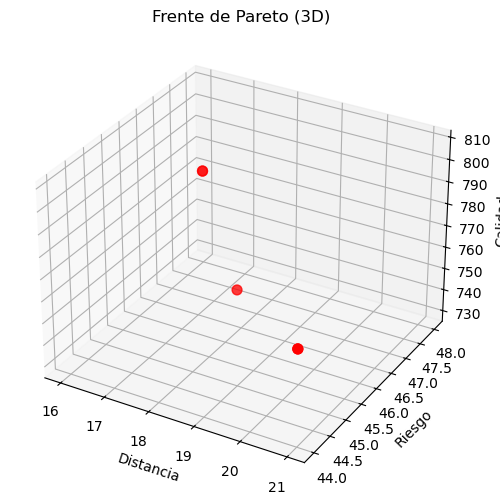

In [6]:
def es_dominada(solucion_i, solucion_j):
    # True si j domina a i
    #j es igual o mejor que a en todos los objetivos. y j es estrictamente mejor que a en al menos uno de los objetivos
    return (
        solucion_j['distancia'] <= solucion_i['distancia'] and
        solucion_j['riesgo'] <= solucion_i['riesgo'] and
        solucion_j['calidad'] >= solucion_i['calidad'] and
        (
            solucion_j['distancia'] < solucion_i['distancia'] or
            solucion_j['riesgo'] < solucion_i['riesgo'] or
            solucion_j['calidad'] > solucion_i['calidad']
        )
    )

def obtener_frente_pareto(resultados):
    frente = []
    for i, res_i in enumerate(resultados):
        dominada = False
        for j, res_j in enumerate(resultados):
            if i != j and es_dominada(res_i, res_j):
                dominada = True
                break
        if not dominada:
            frente.append(res_i)
    return frente


pareto = obtener_frente_pareto(resultados)

# Mostrar
print(" Frente de Pareto ")

import matplotlib.pyplot as plt

# Extraer puntos
x = [r['distancia'] for r in pareto]
y = [r['riesgo'] for r in pareto]
z = [r['calidad'] for r in pareto]

# 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='red', s=50)
ax.set_xlabel('Distancia')
ax.set_ylabel('Riesgo')
ax.set_zlabel('Calidad')
plt.title('Frente de Pareto (3D)')
plt.show()

In [7]:
print ("soluciones")
for i, r in enumerate(resultados):
    print(f"Solución {i+1}: Pesos={r['pesos']} | Distancia={r['distancia']} | Calidad={r['calidad']} | Riesgo={r['riesgo']}")

soluciones
Solución 1: Pesos=(1, 0, 0) | Distancia=16.0 | Calidad=769.0 | Riesgo=48.0
Solución 2: Pesos=(0, 1, 0) | Distancia=30.0 | Calidad=769.0 | Riesgo=51.0
Solución 3: Pesos=(0, 0, 1) | Distancia=24.0 | Calidad=769.0 | Riesgo=44.0
Solución 4: Pesos=(0.33, 0.33, 0.34) | Distancia=16.0 | Calidad=769.0 | Riesgo=48.0
Solución 5: Pesos=(0.7, 0.3, 0.0) | Distancia=16.0 | Calidad=769.0 | Riesgo=52.0
Solución 6: Pesos=(0.2, 0.5, 0.3) | Distancia=16.0 | Calidad=769.0 | Riesgo=48.0
Solución 7: Pesos=(0.1, 0.3, 0.6) | Distancia=21.0 | Calidad=769.0 | Riesgo=44.0
Solución 8: Pesos=(0.5, 0.5, 0.0) | Distancia=16.0 | Calidad=769.0 | Riesgo=51.0
Solución 9: Pesos=(0.0, 0.5, 0.5) | Distancia=25.0 | Calidad=769.0 | Riesgo=44.0
Solución 10: Pesos=(0.5, 0.0, 0.5) | Distancia=16.0 | Calidad=769.0 | Riesgo=48.0
Solución 11: Pesos=(0.2, 0.1, 0.7) | Distancia=19.0 | Calidad=769.0 | Riesgo=45.0
Solución 12: Pesos=(0.6, 0.2, 0.2) | Distancia=16.0 | Calidad=769.0 | Riesgo=48.0
Solución 13: Pesos=(0.1, 0.1,

### Analisis trade off 

En el desarrollo del modelo multiobjetivo para la planificación de rutas de inspección, se observaron distintas compensaciones (trade-offs) entre los tres objetivos considerados: minimizar la distancia total recorrida , maximizar la calidad de inspección acumulada y minimizar el riesgo asociado a la ruta. se encontraron los siguientes ountos relevantes:

**1. Invariancia de la calidad**

Como el modelo fuerza que todas las ciudades sean visitadas una sola vez, la calidad termina siendo la suma de todas las calidades por lo cual no cambia. Se mantiene en un valor de 769 puntos.Esto implica que no se observa trade-off respecto al segundo objetivo (Z₂), pues no hay variabilidad en esa dimensión.

**2. Distancia vs. Riesgo**

Entre estas dos variables si encontramos un trade off muy claro. 
Cuando se prioriza unicamente la distancia, es decir una solucion con pesos de (1,0,0) se logra una distancia minima de 16 y un riesgo de 48. Por otro lado cuando se prioriza el riesgo, (0,0,1), este se reduce a 44 y la distancia aumenta a 24. Cuando se esta priorizando la calidad, podemos ver como ambos, distancia y riesgo tienen un aumento. Distancia con un valor de 30 y riesgo con un valor de 51. 
- Si se prioriza la minimizacion del riesgo, implica rutas mas largas y para la empresa mas costas en logistica. 

- Si se prioriza la minimizacion de distancia, puede implicar rutas mas riesgosas que podrian tener otro tipo de costos para la empresa. 

**3. Combinaciones balanceadas**

Podemos ver que hay soluciones balanceadas que permiten tener una solucion viable. Por ejemplo, (3,1,6) logra una distancia de 21 que no es muy elebada y un riesgo de 44. Una solucion de (2,1,7), ya no es tan balanceada pero presenta un peso en cada necesidad de la empresa nos presenta un resultado de 19 de distancia y 45 de riesgo. Estas soluciones intermedias donde el peso se reparte presentan las mejores soluciones para la empresa. 

### 4. Análisis y Discusión Adicional

Si se llega a a priorizar el costo de los trayectos eso tendria un efecto mayor en la distancia pues al reducir los costos la red tiende a concentrarse en la eficiencia operativa, la minimizacion del uso de los recursos como gasolina y costos de viaje. 

- las rutas seran mas cortas y enfocadas en ir entre ciudades cercanas . El tiempo de entrega y la calidad e la insepccion o la cobertura podrian sufrir por las rutas escogidas para minimizar costso de viaje. 

- La cobertura o las rutas que se seleccionarian serian por lo general las mismas y en un orden que pueda no generar buena cobertura para la empresa. 

- Como vimos en los resultados enteriores, al minimizar la distancia se puede maximizar el riesgo pues no es un factor que entre en consideracion al crear o establecer las rutas. La ruta de (1,0,0) con prioridad de distancia tiene una distancia minima de 16 pero un riesgo de 48. 

Cuando se prioriza una variable como el precio que a fin de cuentas  cambia la distancia, se tiene una aumento en los otros valores pues no se tienen en cuenta para la planificacion del modelo. Si la empresa desea minimizar costos operativos  tienen que saber que estan sacrificando lo demas, lo cual podria causar costos asociados. Ir por rutas peligrosas puede implicar perdida de material, daño de los camiones o de mas revisiones al equipo. 


### Solucion de compromiso mas equilibrada 

Con base en los resultados, consideramos que la Solución 11 (0.2, 0.1, 0.7) representa la solución de compromiso más adecuada:
- Distancia = 19.0: Solo 3 unidades más que el mínimo posible.

- Riesgo = 45.0: Casi el valor mínimo observado.

- Calidad = 769.0: Igual que en todas las soluciones.

Esta solucion le pone un peso y un valor a cada una de las necesidades y nos da unos valores muy balanceados con cada una de las soluciones que tenemos cuando se tiene la prioridad en un solo objetivo. Se tiene una distancia casi minima y un riesgo tambien cercano al minimo calulado. Aumque se prioriza un poco el riesgo no se descuida el componente logistico ni economico. 


El peso asignado a cada objetivo refleja esta intención: se prioriza el riesgo sin descuidar el componente logístico.